# 감귤 착과량 예측 프로젝트 vol.2

In [110]:
import pandas as pd
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rc('font', family='NanumGothic')  # 사용할 폰트 선택

import warnings
warnings.filterwarnings('ignore')


In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import re
from sklearn.cluster import KMeans
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.model_selection import StratifiedKFold

In [112]:
data = pd.read_csv('train.csv')

In [113]:
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [114]:
chlorophyll_dt = [i.split(' ')[0] for i in data.columns if '엽록소' in i]
print('엽록소 데이터 기록 정보: ',chlorophyll_dt[0],'~',chlorophyll_dt[-1],', 총 기록일:',len(chlorophyll_dt))

new_sprout_dt = [i.split(' ')[0] for i in data.columns if '새순' in i]
print('새순 데이터 기록 정보: ',new_sprout_dt[0],'~',new_sprout_dt[-1],', 총 기록일: ',len(new_sprout_dt))

print('---'*10)

print(data['착과량(int)'].describe())


엽록소 데이터 기록 정보:  2022-09-01 ~ 2022-11-28 , 총 기록일: 89
새순 데이터 기록 정보:  2022-09-01 ~ 2022-11-28 , 총 기록일:  89
------------------------------
count    2207.000000
mean      406.222474
std       218.978302
min         1.000000
25%       221.000000
50%       404.000000
75%       593.500000
max       799.000000
Name: 착과량(int), dtype: float64


In [115]:
low_5 = data['착과량(int)'].quantile(0.05)
top_5 = data['착과량(int)'].quantile(0.95)
data = data[(data['착과량(int)']>low_5)&(data['착과량(int)']>low_5)]
# 상,하위 5퍼씩 제거

---

# 1차 데이터 가공 및 예측
- 이 과정에서 가장 성능 좋은 모형이 어떤 변수를 주요하게 다루는지 확인.
- 이후에 주요 변수에 대해 집중적으로 가공하여 예측력을 극대화 하고자 함.

In [116]:
new_sprout_df = data.loc[:,[i for i in data.columns if '새순' in i]]
# 각 나무별 새순정보 삽입
data['새순평균']=new_sprout_df.mean(axis=1)
data['새순최대']=new_sprout_df.max(axis=1)
data['새순최소']=new_sprout_df.min(axis=1)
data['새순표편']=new_sprout_df.std(axis=1)

chlorophyll_df = data.loc[:,[i for i in data.columns if '엽록소' in i]]
# 각 나무별 엽록소정보 삽입
data['엽록소평균']=chlorophyll_df.mean(axis=1)
data['엽록소최대']=chlorophyll_df.max(axis=1)
data['엽록소최소']=chlorophyll_df.min(axis=1)
data['엽록소표편']=chlorophyll_df.std(axis=1)

need_cols=(data.columns[1:6]).tolist()+(data.columns[-8:]).tolist() 

In [117]:
df = data[need_cols]
# 시계열 정보 정리

In [118]:
id_slopes = {}
num_observations = new_sprout_df.shape[1]
x_time = np.arange(num_observations)

for id_value, row_data in new_sprout_df.iterrows():
    y_values = row_data.values  # 해당 ID의 '새순' 값들 (시계열)

    valid_indices = ~np.isnan(y_values)
    y_clean = y_values[valid_indices]
    x_clean = x_time[valid_indices] # y_values와 동일한 위치의 x_time 값들만 선택

    try:
        slope, intercept = np.polyfit(x_clean, y_clean, 1)
        id_slopes[id_value] = slope
    except np.linalg.LinAlgError: # 피팅 중 에러 발생 시 (예: 모든 y값이 동일한 경우 등)
        id_slopes[id_value] = 0.0 # 또는 np.nan 등으로 상황에 맞게 처리
        print(f"ID {id_value}: polyfit 계산 중 에러 발생.")

slopes_series_new = pd.Series(id_slopes, name='새순_기울기')

In [119]:
id_slopes = {}
num_observations = chlorophyll_df.shape[1]
x_time = np.arange(num_observations)

# 각 ID (DataFrame의 각 행)에 대해 반복
for id_value, row_data in chlorophyll_df.iterrows():
    y_values = row_data.values  # 해당 ID의 '엽록소' 값들 (시계열)
    valid_indices = ~np.isnan(y_values)
    y_clean = y_values[valid_indices]
    x_clean = x_time[valid_indices] # y_values와 동일한 위치의 x_time 값들만 선택

    try:
        slope, intercept = np.polyfit(x_clean, y_clean, 1)
        id_slopes[id_value] = slope
    except np.linalg.LinAlgError: # 피팅 중 에러 발생 시 (예: 모든 y값이 동일한 경우 등)
        id_slopes[id_value] = 0.0 # 또는 np.nan 등으로 상황에 맞게 처리
        print(f"ID {id_value}: polyfit 계산 중 에러 발생.")


slopes_series_chl = pd.Series(id_slopes, name='엽록소_기울기')

In [120]:
df

,착과량(int),수고(m),수관폭1(min),수관폭2(max),수관폭평균,새순평균,새순최대,새순최소,새순표편,엽록소평균,엽록소최대,엽록소최소,엽록소표편
0,692,275.0,287.0,292.0,289.5,1.693258,2.8,0.6,0.638143,74.155836,78.336504,70.043251,2.427798
1,534,293.0,284.0,336.0,310.0,1.861798,3.3,0.0,0.894491,74.962123,80.116691,70.427600,2.813831
2,634,300.0,392.0,450.0,421.0,1.762921,3.0,0.5,0.712611,74.727999,79.118529,70.399578,2.476758
3,639,289.0,368.0,379.0,373.5,1.857303,3.1,0.7,0.692802,73.546210,77.936262,69.133970,2.641605
4,496,306.0,353.0,358.0,355.5,2.125843,3.7,0.6,0.898171,71.841067,76.233231,67.410093,2.642378
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2201,572,267.0,299.0,366.0,332.5,1.993258,3.4,0.6,0.840157,70.257683,75.226421,65.668746,2.851198
2202,119,230.0,353.0,367.0,360.0,2.507865,4.7,0.0,1.248565,69.822742,74.024614,65.560547,2.481985
2203,611,266.0,337.0,400.0,368.5,1.841573,3.1,0.6,0.712519,77.262155,81.920876,72.944396,2.681104
2204,650,237.0,353.0,362.0,357.5,1.770787,3.0,0.5,0.723345,71.165328,75.486518,66.479459,2.613637


In [121]:
df['새순기울기'] = slopes_series_new
df['엽록소기울기'] = slopes_series_chl

In [122]:
k_range = range(1, 11)
clust_cols = ['수고(m)','수관폭평균','새순평균','엽록소평균']
inertia_list = []
clust_df = df[clust_cols].copy()
clust_df = np.log(clust_df)
# 로그변환

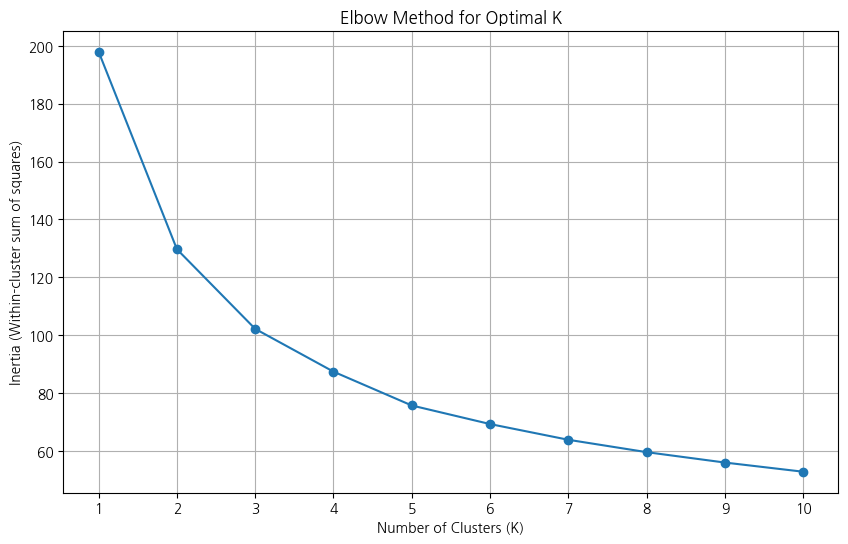

In [123]:
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)

    kmeans.fit(clust_df)

    inertia_list.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))

plt.plot(k_range, inertia_list, marker='o') 
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.xticks(k_range) # x축 눈금을 1부터 10까지 명확하게 표시
plt.grid(True) # 격자 표시
plt.show()

## 엘보 플롯 결과 최적의 k값 3
- 클러스터 내 오차가 완만히 줄어들기 직전 구간은 3이라고 볼 수 있음.

In [124]:
k = 3
kmeans = KMeans(n_clusters=3,n_init=10,random_state=42)
kmeans.fit(clust_df)
df['clust'] = kmeans.labels_

In [125]:
clust_cols.append('착과량(int)')

In [126]:
df.groupby('clust')[clust_cols].mean()

,수고(m),수관폭평균,새순평균,엽록소평균,착과량(int)
clust,,,,,
0,212.757951,258.756184,2.148521,72.515561,409.858657
1,255.622665,367.707347,2.386181,72.257519,261.388543
2,254.444292,364.978680,1.810160,72.672075,621.972490


---

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import *

In [128]:
df['clust'] = df['clust'].astype('category')

clust_dummy = pd.get_dummies(df['clust'],prefix='clust',drop_first=True).astype('int')

df[clust_dummy.columns.tolist()]=clust_dummy

df.drop('clust',axis=1,inplace=True)

In [129]:
# 특징(Features)과 타겟(Target) 분리
X = df.drop('착과량(int)',axis=1)
y = df.loc[:,'착과량(int)']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [149]:
rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'random_state': 42,
}
xgb_params = {
    'n_estimators': 150,
    'max_depth': 15,
    'learning_rate': 0.01, # 학습률을 낮춰 가중치 업데이트를 보수적으로 수행
    'subsample': 0.8,      # 각 트리 학습에 사용되는 데이터 샘플 비율 (과적합 방지)
    'colsample_bytree': 0.7, # 각 트리 학습에 사용되는 특성 비율 (과적합 방지)
    'gamma': 0.1,          # 리프 노드를 추가로 분할하기 위한 최소 손실 감소 (클수록 보수적)
    'reg_alpha': 0.1,      # L1 규제 (특성 선택 효과)
    'reg_lambda': 1,       # L2 규제 (가중치 감소 효과, 기본값)
    'random_state': 42
}

# 파라미터 딕셔너리

In [150]:
# 랜포

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
rf_r2_score = []

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    rf_model = RandomForestRegressor(**rf_params)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_val)
    r2_score_result = r2_score(y_val, rf_predictions)
    mse_score_result = mean_squared_error(y_val, rf_predictions,squared=True)
    rf_r2_score.append(r2_score_result)
    print(f"---------------------------")
    print(f"Fold {fold+1} r2_score: {r2_score_result:.4f}")
    print(f"Fold {fold+1} rmse_score_result: {mse_score_result:.4f}")

print(f"평균 r2_score: {sum(rf_r2_score) / len(rf_r2_score):.4f}")

---------------------------
Fold 1 r2_score: 0.9621
Fold 1 rmse_score_result: 1571.6467
---------------------------
Fold 2 r2_score: 0.9604
Fold 2 rmse_score_result: 1650.6364
---------------------------
Fold 3 r2_score: 0.9632
Fold 3 rmse_score_result: 1568.3537
---------------------------
Fold 4 r2_score: 0.9652
Fold 4 rmse_score_result: 1544.4076
---------------------------
Fold 5 r2_score: 0.9648
Fold 5 rmse_score_result: 1444.7393
평균 r2_score: 0.9631


In [132]:
#xgb

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
xg_r2_score = []

for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    xg_model = XGBRegressor(**xgb_params)
    xg_model.fit(X_train, y_train)
    xg_predictions = xg_model.predict(X_val)
    r2_score_result = r2_score(y_val, xg_predictions)
    mse_score_result = mean_squared_error(y_val, xg_predictions)
    xg_r2_score.append(r2_score_result)
    print(f"---------------------------")
    print(f"Fold {fold+1} r2_score: {r2_score_result:.4f}")
    print(f"Fold {fold+1} rmse_score_result: {mse_score_result:.4f}")

print(f"평균 r2_score: {sum(xg_r2_score) / len(xg_r2_score):.4f}")

---------------------------
Fold 1 r2_score: 0.9125
Fold 1 rmse_score_result: 3629.0522
---------------------------
Fold 2 r2_score: 0.9064
Fold 2 rmse_score_result: 3899.7074
---------------------------
Fold 3 r2_score: 0.9120
Fold 3 rmse_score_result: 3750.8557
---------------------------
Fold 4 r2_score: 0.9144
Fold 4 rmse_score_result: 3794.7580
---------------------------
Fold 5 r2_score: 0.9083
Fold 5 rmse_score_result: 3766.6353
평균 r2_score: 0.9107


In [151]:
rdfm = RandomForestRegressor(**rf_params)

In [152]:
rdfm.fit(X,y)

RandomForestRegressor(max_depth=10, random_state=42)

In [154]:
pd.Series(data=rdfm.feature_importances_,index=rdfm.feature_names_in_).sort_values()

clust_1      0.000035
clust_2      0.000085
새순최소         0.000254
엽록소평균        0.001038
엽록소최대        0.001223
엽록소최소        0.001241
수관폭평균        0.001444
엽록소기울기       0.001580
엽록소표편        0.001665
수관폭2(max)    0.001732
수관폭1(min)    0.001876
수고(m)        0.002363
새순평균         0.006394
새순표편         0.077065
새순기울기        0.150997
새순최대         0.751007
dtype: float64

---

In [27]:
data = pd.read_csv('train.csv')

In [155]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# test_df 변수에 test.csv 파일을 불러옵니다.
test_df = pd.read_csv('test.csv') # 이 부분은 사용자가 직접 실행해야 합니다.

# --- 기본 정보 및 파생변수 생성 ---
# 새순 관련 통계량
new_sprout_df_test = test_df.loc[:, [i for i in test_df.columns if '새순' in i]]
test_df['새순평균'] = new_sprout_df_test.mean(axis=1)
test_df['새순최대'] = new_sprout_df_test.max(axis=1)
test_df['새순최소'] = new_sprout_df_test.min(axis=1)
test_df['새순표편'] = new_sprout_df_test.std(axis=1)

# 엽록소 관련 통계량
chlorophyll_df_test = test_df.loc[:, [i for i in test_df.columns if '엽록소' in i]]
test_df['엽록소평균'] = chlorophyll_df_test.mean(axis=1)
test_df['엽록소최대'] = chlorophyll_df_test.max(axis=1)
test_df['엽록소최소'] = chlorophyll_df_test.min(axis=1)
test_df['엽록소표편'] = chlorophyll_df_test.std(axis=1)

# 새순 기울기
id_slopes_new_test = {}
num_observations_new_test = new_sprout_df_test.shape[1]
x_time_new_test = np.arange(num_observations_new_test)
for id_value, row_data in new_sprout_df_test.iterrows():
    y_values = row_data.values
    valid_indices = ~np.isnan(y_values)
    y_clean = y_values[valid_indices]
    x_clean = x_time_new_test[valid_indices]
    try:
        slope, _ = np.polyfit(x_clean, y_clean, 1)
        id_slopes_new_test[id_value] = slope
    except np.linalg.LinAlgError:
        id_slopes_new_test[id_value] = 0.0
test_df['새순기울기'] = pd.Series(id_slopes_new_test)

# 엽록소 기울기
id_slopes_chl_test = {}
num_observations_chl_test = chlorophyll_df_test.shape[1]
x_time_chl_test = np.arange(num_observations_chl_test)
for id_value, row_data in chlorophyll_df_test.iterrows():
    y_values = row_data.values
    valid_indices = ~np.isnan(y_values)
    y_clean = y_values[valid_indices]
    x_clean = x_time_chl_test[valid_indices]
    try:
        slope, _ = np.polyfit(x_clean, y_clean, 1)
        id_slopes_chl_test[id_value] = slope
    except np.linalg.LinAlgError:
        id_slopes_chl_test[id_value] = 0.0
test_df['엽록소기울기'] = pd.Series(id_slopes_chl_test)


# --- 클러스터링 적용 ---
# train.ipynb에서 학습된 KMeans 모델을 사용해야 합니다.
# clust_cols는 train.ipynb에서 사용된 ['수고(m)', '수관폭평균', '새순평균', '엽록소평균'] 입니다.
# test_df에도 동일한 컬럼이 존재해야 합니다.
clust_cols_for_test = ['수고(m)', '수관폭평균', '새순평균', '엽록소평균']

# test_df에 필요한 컬럼이 모두 있는지 확인
missing_cols = [col for col in clust_cols_for_test if col not in test_df.columns]
if missing_cols:
    print(f"경고: 클러스터링에 필요한 다음 컬럼이 test_df에 없습니다: {missing_cols}")
    # 누락된 컬럼이 있다면 클러스터링 관련 컬럼은 생성하지 않거나, 기본값을 채웁니다.
    # 예시: test_df['clust_1'] = 0
    #       test_df['clust_2'] = 0
else:
    clust_df_test_selected = test_df[clust_cols_for_test].copy()
    clust_df_test_selected = np.log(clust_df_test_selected) # train과 동일하게 로그 변환

    # 중요: 아래 kmeans_train_model은 train.ipynb에서 학습된 KMeans 모델 객체여야 합니다.
    # 예시: from joblib import load
    #       kmeans_train_model = load('kmeans_model.joblib') # 학습된 모델을 불러오는 경우
    # 여기서는 임시로 새로 생성하지만, 실제로는 저장된 train 모델을 사용해야 합니다.
    if 'kmeans' in locals() or 'kmeans' in globals(): # train에서 학습된 kmeans 모델이 있다고 가정
        test_df['clust'] = kmeans.predict(clust_df_test_selected) # fit_predict 대신 predict
    else:
        print("경고: train 데이터로 학습된 KMeans 모델(kmeans)을 찾을 수 없습니다. 클러스터링을 건너<0xEB><0x9C><0x85>니다.")
        # kmeans 모델이 없는 경우, 클러스터 컬럼을 기본값으로 채울 수 있습니다.
        test_df['clust_1'] = 0 # 또는 다른 적절한 기본값
        test_df['clust_2'] = 0 # 또는 다른 적절한 기본값

    if 'clust' in test_df.columns:
        test_df['clust'] = test_df['clust'].astype('category')
        clust_dummy_test = pd.get_dummies(test_df['clust'], prefix='clust', drop_first=True).astype('int')

        # clust_1, clust_2가 생성되도록 보장 (train과 동일하게 k=3 가정, drop_first=True이므로)
        if 'clust_1' not in clust_dummy_test.columns:
            clust_dummy_test['clust_1'] = 0
        if 'clust_2' not in clust_dummy_test.columns:
            clust_dummy_test['clust_2'] = 0

        test_df = pd.concat([test_df, clust_dummy_test[['clust_1', 'clust_2']]], axis=1)
        test_df.drop('clust', axis=1, inplace=True, errors='ignore')


# --- 최종 df_test 컬럼 선택 및 순서 지정 ---
# 이미지에 명시된 컬럼 순서대로 df_test를 구성합니다.
# (주의: test_df에 해당 컬럼들이 모두 생성되어 있어야 합니다.)
final_columns_test = [
    '수고(m)', '수관폭1(min)', '수관폭2(max)', '수관폭평균',
    '새순평균', '새순최대', '새순최소', '새순표편',
    '엽록소평균', '엽록소최대', '엽록소최소', '엽록소표편',
    '새순기울기', '엽록소기울기'
    # 클러스터 컬럼은 위에서 조건부로 생성되므로, 있는 경우에만 추가
]

# 클러스터 컬럼 추가 (존재하는 경우)
if 'clust_1' in test_df.columns:
    final_columns_test.append('clust_1')
if 'clust_2' in test_df.columns:
    final_columns_test.append('clust_2')

# df_test에 없는 컬럼은 생성 시점에서 오류가 발생할 수 있으므로,
# 실제 test_df에 있는 컬럼만으로 final_columns_test를 필터링합니다.
existing_final_columns = [col for col in final_columns_test if col in test_df.columns]

df_test_final = test_df[existing_final_columns].copy()

# print(df_test_final.head()) # 전처리된 test 데이터 확인

In [156]:
result = rdfm.predict(df_test_final)
result_df = test_df[['ID']]
result_df['착과량(int)']=result

In [ ]:
result_df.to_csv('result_v2.csv',index=False)

---

In [28]:
low_5 = data['착과량(int)'].quantile(0.05)
top_5 = data['착과량(int)'].quantile(0.95)
data = data[(data['착과량(int)']>low_5)&(data['착과량(int)']>low_5)]
# 상,하위 5퍼씩 제거

In [29]:
new_sprout_df = data.loc[:,[i for i in data.columns if '새순' in i]]
# 각 나무별 새순정보 삽입
data['새순평균']=new_sprout_df.mean(axis=1)
data['새순최대']=new_sprout_df.max(axis=1)
data['새순최소']=new_sprout_df.min(axis=1)
data['새순표편']=new_sprout_df.std(axis=1)

chlorophyll_df = data.loc[:,[i for i in data.columns if '엽록소' in i]]
# 각 나무별 엽록소정보 삽입
data['엽록소평균']=chlorophyll_df.mean(axis=1)
data['엽록소최대']=chlorophyll_df.max(axis=1)
data['엽록소최소']=chlorophyll_df.min(axis=1)
data['엽록소표편']=chlorophyll_df.std(axis=1)

need_cols=(data.columns[-8:]).tolist() 

In [30]:
df = data[need_cols]

In [31]:
df['착과량(int)'] = data['착과량(int)']

In [32]:
import pandas as pd
import numpy as np

# --- 중요 ---
# 아래 코드를 실행하기 전에, 파이썬 환경에
# 'new_sprout_df'와 'chlorophyll_df'라는 이름의
# Pandas DataFrame이 이미 로드되어 있어야 합니다.
# 예시 (실제로는 사용자의 환경에 맞게 데이터를 로드해야 합니다):
# new_sprout_df = pd.read_csv('path/to/your/new_sprout_data.csv', index_col=0)
# chlorophyll_df = pd.read_csv('path/to/your/chlorophyll_data.csv', index_col=0)
# --------------------------------------------------------------------------

# 1. 월별 통계 계산 함수 정의
def calculate_monthly_item_stats(input_df, item_name_for_output, date_col_suffix):
    """
    주어진 데이터프레임의 각 행에 대해 월별 기술 통계(최대, 최소, 평균, 표준편차)를 계산합니다.

    Parameters:
    input_df (pd.DataFrame): 통계를 계산할 원본 데이터프레임.
    item_name_for_output (str): 결과 열 이름에 사용할 항목 이름 (예: '새순', '엽록소').
    date_col_suffix (str): 데이터프레임 열 이름에서 날짜를 추출할 때 제거할 접미사.
                             (예: ' 새순', ' 엽록소' - 앞에 공백 주의).

    Returns:
    pd.DataFrame: 각 행별, 월별, 통계량별 결과가 열로 포함된 데이터프레임.
    """
    
    df_calc = input_df.copy()
    
    original_columns = df_calc.columns
    datetime_columns = []
    valid_cols_data = {} 

    for col in original_columns:
        date_str = str(col) 
        # 열 이름이 정확히 date_col_suffix로 끝나는 경우에만 처리
        if date_col_suffix and date_str.endswith(date_col_suffix):
            date_str = date_str[:-len(date_col_suffix)]
        # 접미사가 없는 경우, 또는 접미사를 제거한 문자열을 날짜로 변환 시도
        # (만약 접미사가 필수라면, 위 if문 밖에서 날짜 변환을 시도하지 않도록 조정 필요)
        # 현재는 접미사가 없거나, 제거 후 남은 문자열을 날짜로 시도.
        
        try:
            dt_col = pd.to_datetime(date_str)
            datetime_columns.append(dt_col)
            # 원본 열 이름을 사용해야 df_calc에서 올바른 데이터를 가져옴
            valid_cols_data[dt_col] = col 
        except (ValueError, TypeError):
            # 날짜로 변환할 수 없는 열은 무시 (예: ID 열 또는 다른 문자열 열)
            # print(f"정보: 열 '{col}' (처리 후: '{date_str}')은 날짜 형식이 아니므로 통계 계산에서 제외됩니다.")
            pass 
    
    if not datetime_columns:
        print(f"주의: '{item_name_for_output}' 항목에 대한 유효한 날짜 열을 찾을 수 없습니다. 빈 통계 DataFrame을 반환합니다.")
        return pd.DataFrame(index=input_df.index)

    # 유효한 날짜로 변환된 열들만 사용하여 데이터프레임 재구성
    # 날짜 순으로 정렬하여 월별 그룹화가 올바르게 되도록 함
    sorted_dt_cols = sorted(datetime_columns)
    df_calc = df_calc[[valid_cols_data[dt] for dt in sorted_dt_cols]]
    df_calc.columns = pd.DatetimeIndex(sorted_dt_cols)

    all_rows_stats_list = []
    agg_funcs = ['max', 'min', 'mean', 'std']
    agg_funcs_korean = {'max': '최대', 'min': '최소', 'mean': '평균', 'std': '표준편차'}

    for index, row_series in df_calc.iterrows():
        if row_series.empty or row_series.isnull().all():
            # 빈 행이나 모든 값이 NaN인 행에 대한 처리
            # 예상되는 월 목록 가져오기 (데이터가 있는 열 기준)
            expected_months = df_calc.columns.month.unique()
            # 모든 월에 대해 모든 통계량을 NaN으로 채운 Series 생성
            multi_idx_tuples = []
            for month in expected_months:
                for stat_func_key in agg_funcs: # agg_funcs_korean의 키 사용
                    stat_name_korean = agg_funcs_korean[stat_func_key]
                    multi_idx_tuples.append(f'{month}월_{item_name_for_output}_{stat_name_korean}')
            
            if multi_idx_tuples:
                empty_stats_series = pd.Series(index=multi_idx_tuples, data=np.nan, dtype=float)
            else: # df_calc에 유효한 날짜 열이 하나도 없었던 극단적 경우 (위에서 이미 처리됨)
                empty_stats_series = pd.Series(dtype=float)

            all_rows_stats_list.append(empty_stats_series)
            continue

        monthly_stats_for_row = row_series.groupby(row_series.index.month).agg(agg_funcs)
        
        # 월별 데이터가 없는 경우 unstack() 전에 빈 DataFrame이 될 수 있음.
        if monthly_stats_for_row.empty:
            # 이 경우에도 위와 유사하게 NaN으로 채워진 Series를 만들어야 함.
            expected_months = df_calc.columns.month.unique()
            multi_idx_tuples = []
            for month in expected_months:
                for stat_func_key in agg_funcs:
                    stat_name_korean = agg_funcs_korean[stat_func_key]
                    multi_idx_tuples.append(f'{month}월_{item_name_for_output}_{stat_name_korean}')
            if multi_idx_tuples:
                empty_stats_series = pd.Series(index=multi_idx_tuples, data=np.nan, dtype=float)
            else:
                empty_stats_series = pd.Series(dtype=float)
            all_rows_stats_list.append(empty_stats_series)
            continue
            
        stats_unstacked = monthly_stats_for_row.unstack() # (통계함수, 월) MultiIndex
        
        new_column_names = []
        if not stats_unstacked.empty:
            for stat_func, month in stats_unstacked.index: 
                stat_name_korean = agg_funcs_korean.get(stat_func, stat_func)
                new_column_names.append(f'{month}월_{item_name_for_output}_{stat_name_korean}')
            stats_unstacked.index = new_column_names
        all_rows_stats_list.append(stats_unstacked)

    result_df = pd.DataFrame(all_rows_stats_list, index=input_df.index)
    return result_df

# --- 실제 연산 부분 ---
# 이 시점에서 new_sprout_df와 chlorophyll_df는 사용자의 환경에 이미 로드되어 있어야 합니다.

# 2. 각 데이터프레임별 통계 계산
# new_sprout_df의 열 이름이 'YYYY-MM-DD 새순' 형식이라고 가정 (앞 공백 포함)
sprout_stats_df = calculate_monthly_item_stats(new_sprout_df, 
                                               item_name_for_output='새순', 
                                               date_col_suffix=' 새순')

# chlorophyll_df의 열 이름이 'YYYY-MM-DD 엽록소' 형식이라고 가정 (앞 공백 포함)
chloro_stats_df = calculate_monthly_item_stats(chlorophyll_df, 
                                               item_name_for_output='엽록소', 
                                               date_col_suffix=' 엽록소')

In [33]:
df = pd.concat([df,sprout_stats_df],axis=1)
df = pd.concat([df,chloro_stats_df],axis=1)


In [34]:
id_slopes = {}
num_observations = new_sprout_df.shape[1]
x_time = np.arange(num_observations)

for id_value, row_data in new_sprout_df.iterrows():
    y_values = row_data.values  # 해당 ID의 '새순' 값들 (시계열)

    valid_indices = ~np.isnan(y_values)
    y_clean = y_values[valid_indices]
    x_clean = x_time[valid_indices] # y_values와 동일한 위치의 x_time 값들만 선택

    try:
        slope, intercept = np.polyfit(x_clean, y_clean, 1)
        id_slopes[id_value] = slope
    except np.linalg.LinAlgError: # 피팅 중 에러 발생 시 (예: 모든 y값이 동일한 경우 등)
        id_slopes[id_value] = 0.0 # 또는 np.nan 등으로 상황에 맞게 처리
        print(f"ID {id_value}: polyfit 계산 중 에러 발생.")

slopes_series_new = pd.Series(id_slopes, name='새순_기울기')

In [35]:
id_slopes = {}
num_observations = chlorophyll_df.shape[1]
x_time = np.arange(num_observations)

for id_value, row_data in chlorophyll_df.iterrows():
    y_values = row_data.values  # 해당 ID의 '새순' 값들 (시계열)

    valid_indices = ~np.isnan(y_values)
    y_clean = y_values[valid_indices]
    x_clean = x_time[valid_indices] # y_values와 동일한 위치의 x_time 값들만 선택

    try:
        slope, intercept = np.polyfit(x_clean, y_clean, 1)
        id_slopes[id_value] = slope
    except np.linalg.LinAlgError: # 피팅 중 에러 발생 시 (예: 모든 y값이 동일한 경우 등)
        id_slopes[id_value] = 0.0 # 또는 np.nan 등으로 상황에 맞게 처리
        print(f"ID {id_value}: polyfit 계산 중 에러 발생.")

slopes_series_chl = pd.Series(id_slopes, name='엽록소_기울기')

In [36]:
df['새순기울기'] = slopes_series_new
df['엽록소기울기'] = slopes_series_chl

In [38]:
df.columns

Index(['새순평균', '새순최대', '새순최소', '새순표편', '엽록소평균', '엽록소최대', '엽록소최소', '엽록소표편',
       '착과량(int)', '9월_새순_최대', '10월_새순_최대', '11월_새순_최대', '9월_새순_최소',
       '10월_새순_최소', '11월_새순_최소', '9월_새순_평균', '10월_새순_평균', '11월_새순_평균',
       '9월_새순_표준편차', '10월_새순_표준편차', '11월_새순_표준편차', '9월_엽록소_최대', '10월_엽록소_최대',
       '11월_엽록소_최대', '9월_엽록소_최소', '10월_엽록소_최소', '11월_엽록소_최소', '9월_엽록소_평균',
       '10월_엽록소_평균', '11월_엽록소_평균', '9월_엽록소_표준편차', '10월_엽록소_표준편차',
       '11월_엽록소_표준편차', '새순기울기', '엽록소기울기'],
      dtype='object')

---

In [42]:
# 특징(Features)과 타겟(Target) 분리
X = df.drop('착과량(int)',axis=1)
y = df.loc[:,'착과량(int)']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
bs_model = RandomForestRegressor(**rf_params)

In [52]:
bs_model.fit(X_train,y_train)
bs_pred = bs_model.predict(X_test)
print(r2_score(y_test,bs_pred))
print(mean_squared_error(y_test,bs_pred))

0.9683306656245358
1324.602378682309
